In [1]:
# 라이브러리 추가
import urllib.request
import json
import pandas as pd
import seaborn as sns; sns.set(style='darkgrid', font='KoPubDotum', font_scale=1.5)
import matplotlib.pyplot as plt

In [2]:
# 데이터랩 API를 이용한 검색량 조회 함수(최대 5개)
def datalab_api(keywords):

    # 데이터랩 API
    client_id = "89L30Y3xCshEctCoab1v"
    client_secret = "aIoL3WXAsj"

    url = "https://openapi.naver.com/v1/datalab/search"

    body = {
        "startDate":"2016-01-01",
        "endDate":"2019-06-30",
        "timeUnit":"date",
        "keywordGroups":[
            {"groupName":str(keywords[0]),"keywords":[str(keywords[0])]},
            {"groupName":str(keywords[1]),"keywords":[str(keywords[1])]},
            {"groupName":str(keywords[2]),"keywords":[str(keywords[2])]},
            {"groupName":str(keywords[3]),"keywords":[str(keywords[3])]},
            {"groupName":str(keywords[4]),"keywords":[str(keywords[4])]},
        ],
    }
    body = json.dumps(body)

    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    request.add_header("Content-Type","application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))
    json_obj = json.loads(response.read().decode('utf-8'))

    # 데이터프레임
    df1 = pd.DataFrame(json_obj['results'][0]['data']); df1.columns=['기간', str(keywords[0])]
    df2 = pd.DataFrame(json_obj['results'][1]['data']); df2.columns=['기간', str(keywords[1])]
    df3 = pd.DataFrame(json_obj['results'][2]['data']); df3.columns=['기간', str(keywords[2])]
    df4 = pd.DataFrame(json_obj['results'][3]['data']); df4.columns=['기간', str(keywords[3])]
    df5 = pd.DataFrame(json_obj['results'][4]['data']); df5.columns=['기간', str(keywords[4])]
    
    # 데이터프레임 병합
    df2 = df1.merge(df2, how='outer', on='기간').fillna(0)
    df3 = df2.merge(df3, how='outer', on='기간').fillna(0)
    df4 = df3.merge(df4, how='outer', on='기간').fillna(0)
    df5 = df4.merge(df5, how='outer', on='기간').fillna(0)
    
    return df5

In [3]:
# 최소-최대 정규화를 적용한 데이터랩 검색량 조회 함수 (무제한)
def datalab_api_kw_list(kw_list):

    # df: '국립공원' 검색량 최소값, 최대값
    df = datalab_api(kw_list[0]+kw_list[1])
    a, b = df.iloc[:,1].min(), df.iloc[:,1].max()

    i=2
    while i < len(kw_list):
        df1 = datalab_api(kw_list[0]+kw_list[i])
        # df1: 국립공원 컬럼의 최소값, 최대값
        x, y = df1.iloc[:,1].min(), df1.iloc[:,1].max()
        # 최소-최대 정규화
        df1.iloc[:,2] = (df1.iloc[:,2] - x) / (y - x) * (b - a) + a
        df1.iloc[:,3] = (df1.iloc[:,3] - x) / (y - x) * (b - a) + a
        df1.iloc[:,4] = (df1.iloc[:,4] - x) / (y - x) * (b - a) + a
        df1.iloc[:,5] = (df1.iloc[:,5] - x) / (y - x) * (b - a) + a
        df1 = df1.drop(columns=['기간', '국립공원'])
        df = pd.concat([df, df1], axis=1)
        i+=1
    
    # '테스트' 검색량 삭제
    df = df[df.columns.drop(list(df.filter(regex='테스트')))]
    
    return df

In [4]:
# 키워드 리스트
kw_list = [['국립공원'], ['깃대종', '테스트', '테스트', '테스트']]

In [5]:
df = datalab_api_kw_list(kw_list)
df.to_excel('D:/GEODATA/RSRCH02.xlsx')
df.head()

,기간,국립공원,깃대종
0,2016-01-01,9.60000,0.00000
1,2016-01-02,9.27407,0.14814
2,2016-01-03,8.65185,0.23703
3,2016-01-04,14.07407,0.41481
4,2016-01-05,11.49629,0.59259


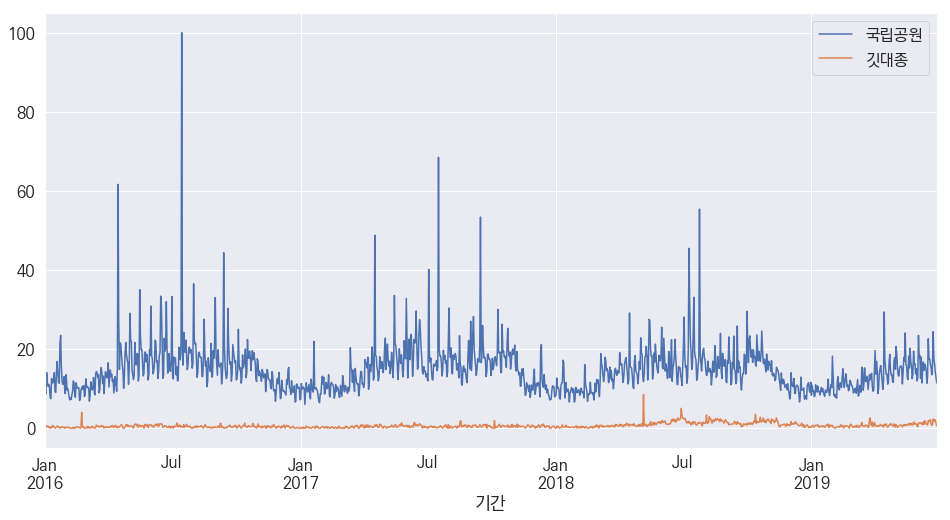

In [6]:
# '국립공원', '깃대종' 검색량 라인 플롯
df = pd.read_excel('D:/GEODATA/RSRCH02.xlsx', sheet_name='Sheet1' ,index_col='기간', parse_dates=True).drop(['Unnamed: 0'], axis=1)
df.plot(figsize=(16, 8))
plt.savefig('D:/GEODATA/IMG01.png', bbox_inches='tight')

In [7]:
# 연평균
df.groupby(df.index.year).mean()

,국립공원,깃대종
기간,,
2016,15.207200,0.386962
2017,15.153806,0.402877
2018,14.594820,1.095398
2019,13.007894,0.748267


In [8]:
print('국립공원 검색량: ' + format(df.mean()['국립공원'], ".2f"))
print('깃대종 검색량: ' + format(df.mean()['깃대종'], ".2f"))
print('깃대종 검색량: ' + format(df.mean()['깃대종'] / df.mean()['국립공원'], ".2f") + '배')

국립공원 검색량: 14.71
깃대종 검색량: 0.65
깃대종 검색량: 0.04배


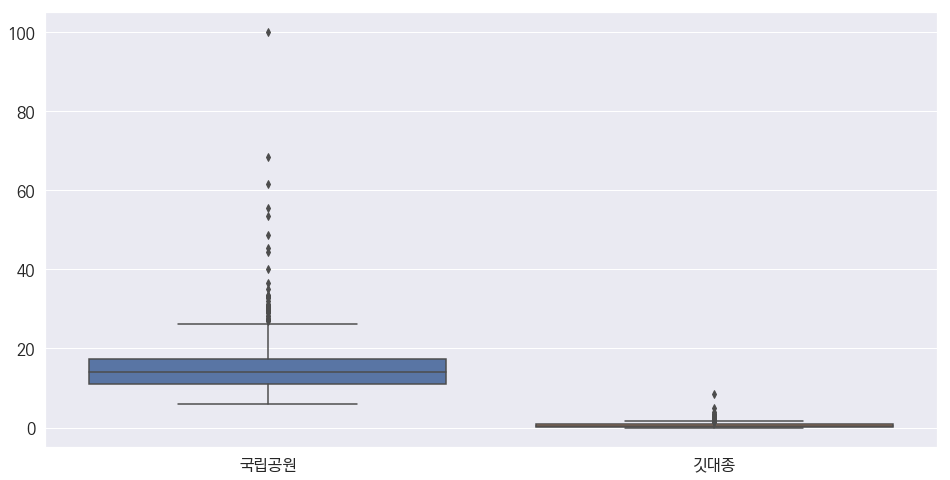

In [9]:
# '국립공원'과 '깃대종' 검색량 박스 플롯
plt.figure(figsize=(16, 8))
sns.boxplot(data=df[['국립공원', '깃대종']])
plt.savefig('D:/GEODATA/IMG02.png', bbox_inches='tight')

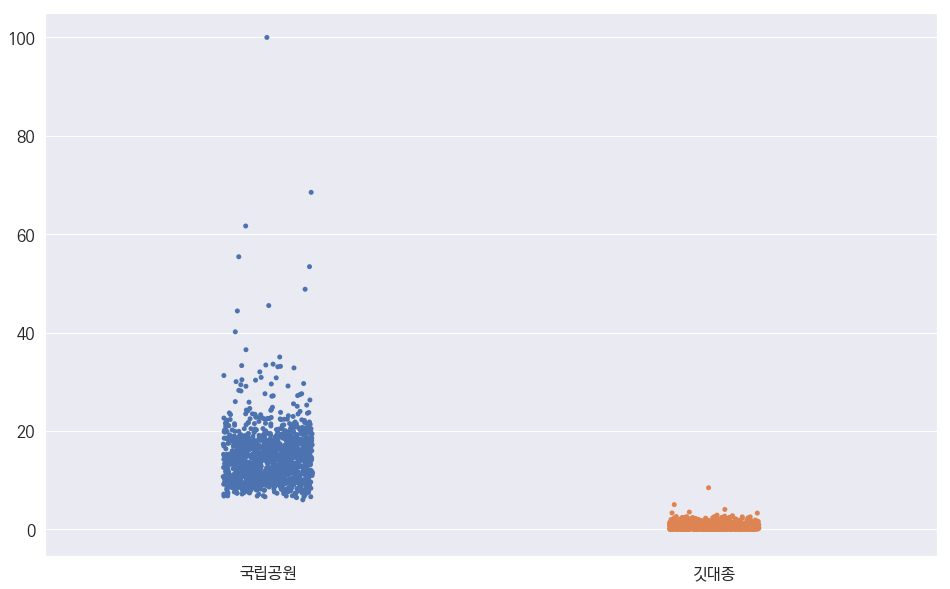

In [10]:
# '국립공원', '깃대종' 닷 플롯
plt.figure(figsize=(16, 10))
sns.stripplot(data=df[['국립공원', '깃대종']])
plt.savefig('D:/GEODATA/IMG03.png', bbox_inches='tight')

In [11]:
# 퍼센트 변화
df.groupby(df.index.year).mean().pct_change()*100

,국립공원,깃대종
기간,,
2016,NaN,NaN
2017,-0.351115,4.113021
2018,-3.688749,171.893739
2019,-10.873215,-31.690007


In [12]:
# 최근 4년간 퍼센트 변화
df.groupby(df.index.year).mean().iloc[[0, 3],:].pct_change()*100

,국립공원,깃대종
기간,,
2016,NaN,NaN
2019,-14.462272,93.369731


In [13]:
# 피어슨 상관계수
print('깃대종 상관계수: ' + format(df.corrwith(df['국립공원'], method='pearson')['깃대종'], ".2f"))

깃대종 상관계수: 0.20


In [14]:
# 연월평균 검색량
df['Year'] = df.index.year; df['Month'] = df.index.month
df = df.groupby(by=[df.index.year, df.index.month]).mean()

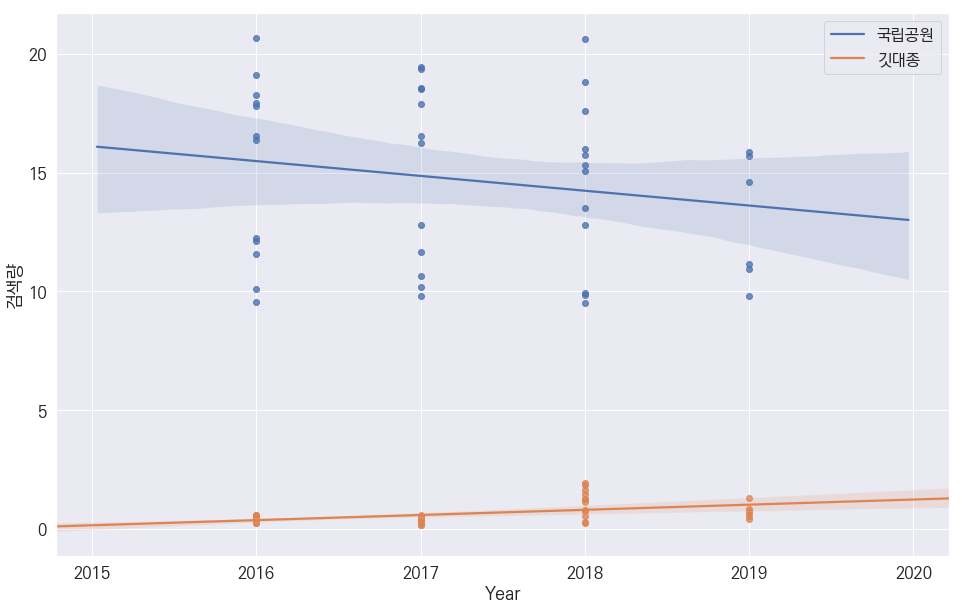

In [15]:
# '국립공원', '깃대종'검색량 회귀 플롯
plt.figure(figsize=(16, 10))
sns.regplot(x=df['Year'], y=df['국립공원'], data=df, order=1)
sns.regplot(x=df['Year'], y=df['깃대종'], data=df, order=1)
plt.ylabel('검색량')
plt.legend(labels=['국립공원', '깃대종'])
plt.savefig('D:/GEODATA/IMG04.png', bbox_inches='tight')
plt.show()

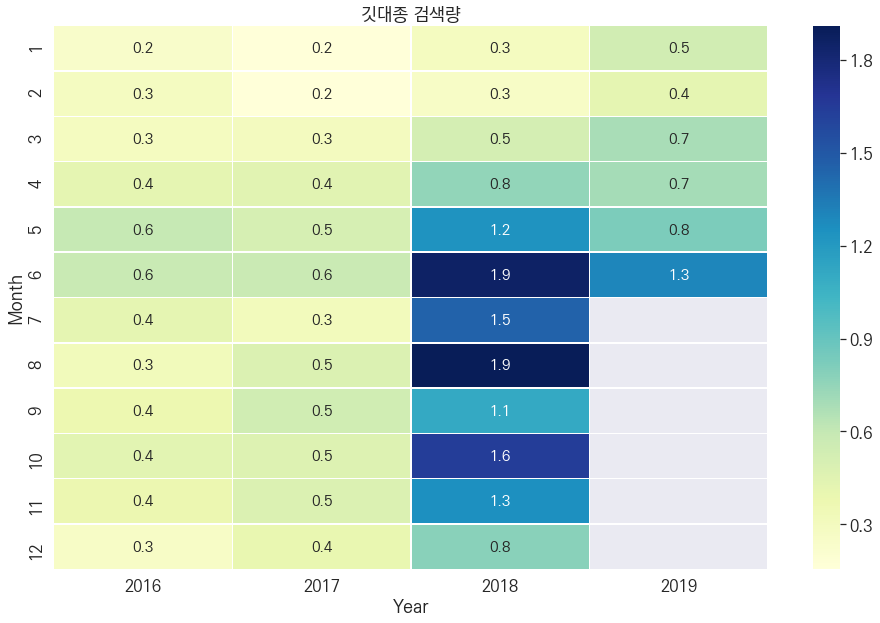

In [16]:
# '깃대종' 열지도
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(df.pivot("Month", "Year", "깃대종"), cmap="YlGnBu",
            annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax)
ax.set_title('깃대종 검색량')
plt.savefig('D:/GEODATA/IMG05.png', bbox_inches='tight')

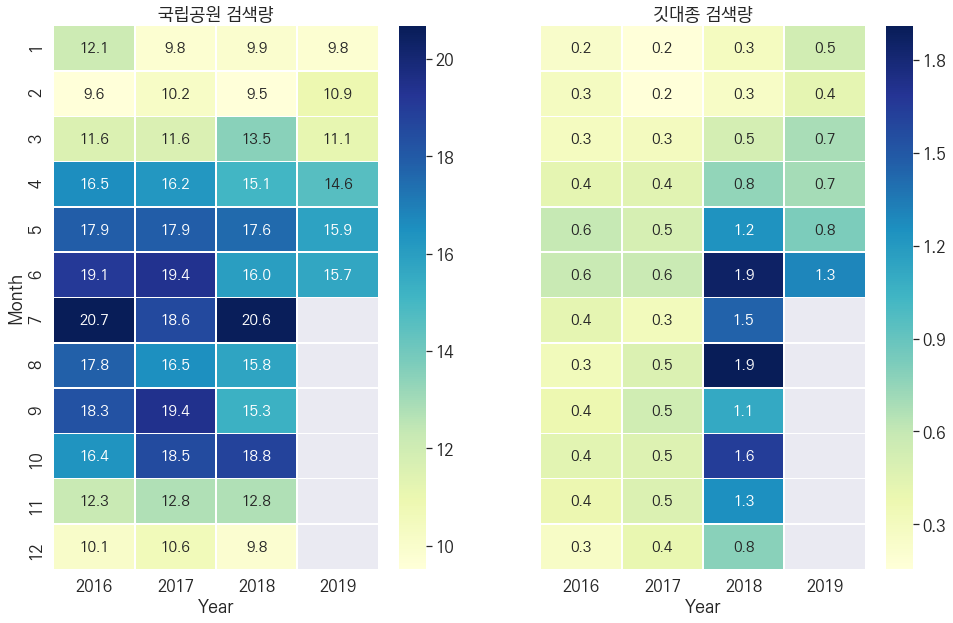

In [17]:
# '국립공원', '국립공원관리공단', '국립공원공단'검색량 열지도
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
sns.heatmap(df.pivot("Month", "Year", "국립공원"), cmap="YlGnBu",
            annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax1)
sns.heatmap(df.pivot("Month", "Year", "깃대종"), cmap="YlGnBu",
            annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax2)

ax1.set_title('국립공원 검색량')
ax2.set_title('깃대종 검색량')
ax2.set_yticklabels([]); ax2.set_ylabel("")
plt.savefig('D:/GEODATA/IMG06.png', bbox_inches='tight')

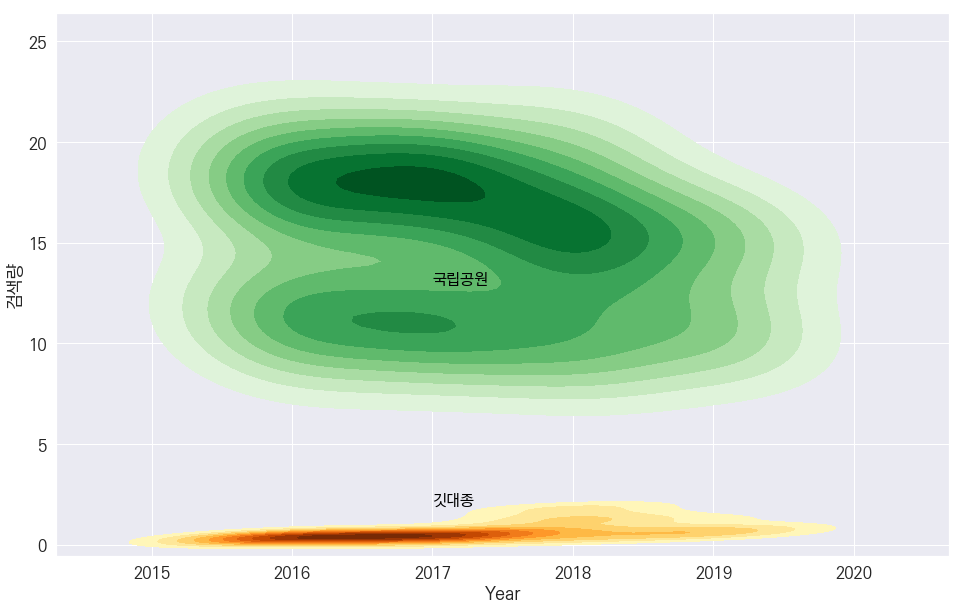

In [18]:
# '국립공원', '국립공원관리공단' KDE 플롯
# Draw the two density plots
f, ax = plt.subplots(figsize=(16, 10))
sns.kdeplot(df['Year'], df['국립공원'], cmap="Greens", shade=True, shade_lowest=False)
sns.kdeplot(df['Year'], df['깃대종'], cmap="YlOrBr", shade=True, shade_lowest=False)

# Add labels to the plot
ax.text(2017, 13, "국립공원", size=16, color='black')
ax.text(2017, 2, "깃대종", size=16, color='black')
plt.ylabel('검색량')
plt.savefig('D:/GEODATA/IMG07.png', bbox_inches='tight')
plt.show()